In [ ]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
from scipy.spatial import KDTree
import numba
from sklearn.utils import resample
import matplotlib.patches as mpatches
from itertools import chain

random.seed(0)
warnings.filterwarnings('ignore', category=UserWarning)

# Problem Statement

We define the problem in terms of supervised learning. Consider a dataset of $N$ points with $f$ features with two classes, one denoting the point as "unhealthy" and the other as "healthy." 

We apply an AI model (model-agnostic) such that the model learns a decision boundary or contour between the two classes. 

For the problem, we want to find the closest distance from any given unhealthy point to the decision boundary. We mean that among all points in the decision boundary, which point will be closest to the point? 

Additionally, given a set of constraints in $f$ dimensions or fewer, what is the closest point satisfying the constraints to the decision boundary? If constraints are defined for all $f$ dimensions, there would be a box around the original "unhealthy" point. What point lies on the box closest to the decision boundary?

# Goals for the Problem Statement 

1. Find the Decision Boundary for any model defined on a dataset of $N$ points with $f$ within the binary classification case. The Boundary must be model-agnostic and work for any dataset (invariant to the number of features and data points). 
2. We must find the closest distance from a given unhealthy data point (from 1.) to the decision boundary. This must work in any Euclidean space of dimension $R^f$ so that it can work with any dataset. 
3. Given a set of constraints in $f$ dimensions or fewer, what is the closest point satisfying the constraints to the decision boundary? We will show examples in 2D. 
4. Can we apply real-world constraints to a given problem to reduce the number of points that we need to search for? 

# Importing the Dataset and Creating the Model

Below, we import the toy dataset into the Jupiter Notebook. This dataset consists of $20$ points, which are one of two classes, either "healthy" or "unhealthy." The "unhealthy" points are colored red, whereas the healthy points are colored blue.

We create an SVM classifier to apply to the toy dataset.

In [79]:
# Reading in the dataset
df=pd.read_csv('toy_dataset.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

In [3]:
%load_ext cuml.accel

# Visualizing the Dataset

Below, we show a visualization of the dataset on two features ($x_1$ and $x_2$), and we label each of the data points as one of two classes ("healthy" or "unhealthy")

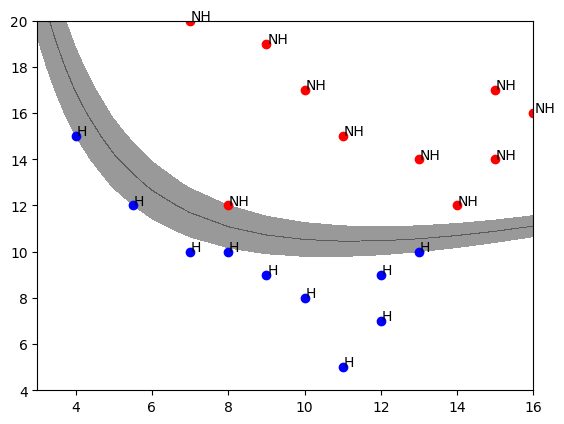

In [ ]:
def visualize_dataset():
    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values
    # svm_classifier = svm.SVC(kernel='linear', C=10)
    #svm_classifier = svm.SVC(kernel='poly', C=10)
    svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
    # svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
    svm_classifier.fit(X_train, y_train)
    color_ls = []
    for k in y_train:
        if k == 1:
            color_ls.append('b')
        else:
            color_ls.append('r')
    color_ls
    label = []
    for k in y_train:
        if k == 1:
            label.append('H')
        else:
            label.append('NH')
    label
    def plot_decision_boundary(clf, X, y):
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max),np.arange(x2_min, x2_max))
        Z = clf.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        m = np.nonzero(Z < -19)
        Q = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, colors='k', levels=[-1, 0, 1], alpha=0.4,linestyles=['--', '-', '--'])
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

    plot_decision_boundary(svm_classifier, X_train, y_train)

    for k, (i,j) in enumerate(X_train):
        plt.scatter(i, j, c = color_ls[k])
        plt.text(i+0.02, j+0.02, label[k])

visualize_dataset()

# Closest Point Functions 

```closest_point()``` - computes the closest distance from a point in $R^f$ from the decision boundary usually defined as a numpy array of points in $R^f$ where $f$ is the number of features 

```closest_border_point()``` - This computes the closest distance from a set of border points from the decision boundary. Border points are defined with constraints around the original unhealthy point. Generating a box around an unhealthy point will determine the closest distance from the box to the decision boundary.


```euclidean_distance()``` - This computes the euclidean distance between two points (A,B) in any $n$ dimensional Euclidean space where $n > 0$

# Displacement Function 

```move_from_A_to_B_with_x1_displacement()``` - moves from a given point A to another point B with a displacement value delta 

In [ ]:

def move_from_A_to_B_with_x1_displacement(A, B, deltas, epsilon=1e-3):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.

    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension

    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)

    # Calculate direction vector from A to B
    D = B - A

    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / (D + epsilon)   # D[0] is the x1 component of the direction vector

    # Calculate the new point P based on t
    P = A + t * D

    print(t)
    print(D)

    return P

def closest_point(point, contour):
    """
    Finds the closest point on a contour to a given reference point.

    Parameters:
    -----------
    point : array-like or tuple
        A single point (e.g., [x, y]) for which the nearest contour point is to be found.

    contour : array-like of shape (n_points, n_dimensions)
        A list or array of points representing the contour. Each point should have the same dimensionality as `point`.

    Returns:
    --------
    closest_point : array-like
        The point on the contour that is closest to the input `point`.
    """

    # Build a KD-tree for fast nearest neighbor search over the contour points
    tree = KDTree(contour)

    # Find the index of the contour point closest to the input point
    closest_index = tree.query(point)[1]

    # If the result is an array (e.g., due to batch input), extract the scalar index
    if not isinstance(closest_index, np.int64):
        closest_index = closest_index[0]

    # Retrieve the actual closest point using the index
    closest_point = contour[closest_index]

    return closest_point

def closest_border_point(border_points, contour):
    """
    Finds the point in `border_points` that is closest to any point in the given `contour`.

    Parameters:
    -----------
    border_points : array-like of shape (n_points, n_dimensions)
        A list or array of candidate points (e.g., border or edge points).

    contour : array-like of shape (m_points, n_dimensions)
        A list or array of contour points to which the closest distance is measured.

    Returns:
    --------
    min_point : array-like
        The point from `border_points` that is closest to any point in the `contour`.
    """

    # Build a KDTree for efficient nearest neighbor queries on contour points
    tree = KDTree(contour)

    # Initialize variables to track the closest border point and the smallest distance found
    min_point = None         # Will hold the closest point from `border_points`
    total_min = float('inf') # Initialize the minimum distance as infinity

    # Iterate through each candidate border point
    for border_point in border_points:
        # Query the KDTree to find the distance to the closest contour point
        dist, _ = tree.query(border_point)

        # If this distance is the smallest encountered so far, update tracking variables
        if dist < total_min:
            total_min = dist
            min_point = border_point

    # Return the border point with the minimum distance to the contour
    return min_point

def euclidean_distance(point1, point2):
    """
    Computes the Euclidean distance between two points.

    Parameters:
    -----------
    point1 : array-like
        The first point (e.g., [x1, y1] or [x1, y1, z1]).

    point2 : array-like
        The second point (e.g., [x2, y2] or [x2, y2, z2]).

    Returns:
    --------
    float
        The Euclidean distance between `point1` and `point2`.
    """

    # Convert both points to NumPy arrays, subtract them element-wise,
    # and compute the L2 norm (i.e., Euclidean distance) of the result
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Finding Decision Boundary Points

```find_decision_boundary()``` -- computes the decision boundary points from a generated mesh grid of points 

```prediction()``` -- Looks for the midpoint between two classes and appends them to a list consisting of boundary points

In [ ]:
@numba.njit
def prediction(Z, grid, epsilon):
    """
    Identify points near the decision boundary by finding close pairs of grid points
    with different predicted classes and computing their midpoints.

    Parameters
    ----------
    Z : numpy.ndarray
        Array of predicted class labels for each point in the grid (shape: (n_grid_points,)).

    grid : numpy.ndarray
        Array of grid points in the feature space (shape: (n_grid_points, n_features)).

    epsilon : float
        Maximum distance threshold for considering two points as neighbors. Points
        closer than this with different classes are used to compute boundary midpoints.

    Returns
    -------
    list of numpy.ndarray
        List of midpoint arrays representing approximate boundary points.

    Raises
    ------
    None explicitly, but may raise ValueError if shapes of Z and grid mismatch,
    or if numba compilation fails (if @njit is used without numba installed).

    Notes
    -----
    - This function is JIT-compiled with numba for performance, but can run without it.
      Remove @njit if numba is unavailable.
    - Computational complexity is O(n_grid_points^2), which is inefficient for large grids.
      Suitable only for small grids (e.g., low resolution or few features).
    - Uses Euclidean norm (np.linalg.norm) for distance.
    - Usage: Called internally by boundary computation functions to extract transitions.
    """
    boundary_points = []  # List to collect midpoints
    for i in range(len(grid) - 1):  # Outer loop over grid points
            for j in range(i + 1, len(grid)):  # Inner loop to avoid duplicates/self
                # Check if points are close and have different predictions
                if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                    # Append midpoint as boundary approximation
                    boundary_points.append((grid[i] + grid[j]) / 2)
    return boundary_points

def compute_decision_boundary_points_all_features(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space by
    generating a dense grid, predicting classes, and finding transitions via midpoints.

    Parameters
    ----------
    model : object
        Trained binary or multi-class classifier with a `predict` method that takes
        an array of input points and returns predictions as an array.
        Example: sklearn.linear_model.LogisticRegression instance.

    X : pandas.DataFrame
        Input feature dataset (shape: (n_samples, n_features)). Used to determine
        min/max ranges for numeric features and categories for categorical ones.

    resolution : int, optional
        Number of points to sample along each feature axis for the grid. Higher values
        increase density but exponentially increase memory/computation. Default is 100.

    epsilon : float, optional
        Distance threshold for detecting class changes between grid points. Should be
        tuned based on feature scales (e.g., small for normalized data). Default is 0.01.

    Returns
    -------
    pandas.DataFrame
        DataFrame of unique approximate boundary points, with the same columns as X.

    Raises
    ------
    ValueError
        If grid shapes mismatch during generation, or if model.predict fails.

    MemoryError or OverflowError
        Likely for high resolution or many features due to grid size (resolution ** n_features).

    Notes
    -----
    - Generates a full Cartesian grid over all features, flattened to 1D array.
      For n_features = f, grid size = resolution^f, which is feasible only for small f
      (e.g., f<=3) and low resolution (e.g., <=20). For higher dimensions, consider
      sampling or dimensionality reduction instead.
    - For numeric features: Samples evenly from (min-1, max+1).
    - For categorical features: Maps to integer indices (0 to len(categories)-1).
      Note: The code assumes len(categories) == resolution; otherwise, it may produce
      an incorrect grid size (length mismatch). Consider adjusting resolution to match
      max categories or handling categoricals separately (e.g., one-hot encode beforehand).
    - Predictions are made on the entire grid, then boundary midpoints are found.
    - Unique points are taken to remove duplicates.
    - Usage: Visualize high-D boundaries by projecting (e.g., PCA) or for analysis.
      Best for low-D or with small resolution.

    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> from sklearn.linear_model import LogisticRegression
    >>> X = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0]})
    >>> model = LogisticRegression().fit(X, [0, 1, 0])
    >>> boundary = compute_decision_boundary_points_all_features(model, X, resolution=10, epsilon=0.1)
    >>> print(boundary.shape)  # e.g., (number_of_boundary_points, 2)
    (15, 2)
    """
    n_features = X.shape[1]  # Number of features
    # A grid that contains resolution^f samples from the f dimensional space where f is the number of features
    grid = np.zeros((resolution ** n_features, n_features))  # Initialize grid array

    # Generates a grid that contains resolution^f samples based on whether the column contains numeric or categorical values
    # If the column contains numeric types, then the grid generates a column based on subdividing the numeric columns evenly
    for i in range(n_features):
        # Checks if the column is not a column consisting of categorical values
        # If it is not categorical, then the column must be numeric.
        if not isinstance(X[X.columns[i]].dtype, pd.CategoricalDtype):
            # Sample evenly spaced points, slightly extended beyond data range
            grid[:, i] = np.tile(np.linspace(X.iloc[:, i].min() - 1, X.iloc[:, i].max() + 1, resolution).repeat(resolution ** (n_features - i - 1)), resolution ** i)
        else:
            # For categorical: Get unique categories and map to integers
            cat_array = X.iloc[:, i].astype('category').cat.categories
            cat_array = np.arange(len(cat_array))  # e.g., [0, 1, 2] for 3 categories
            repeats_per_cat = resolution ** (n_features - i - 1)
            tiles = resolution ** i
            col_values = np.tile(np.repeat(cat_array, repeats_per_cat), tiles)
            grid[:, i] = col_values  # Assign to grid; note: length must match resolution^n_features

    # Predict the class for each point in the grid
    Z = model.predict(grid)
    # Find points near the decision boundary
    boundary_points = prediction(Z, grid, epsilon)

    if len(boundary_points) == 0:
         raise Exception("No Boundary Points Found. The DataFrame is empty. Please try to change the parameters.")

    return pd.DataFrame(np.unique(boundary_points,axis=0), columns=X.columns)  # Unique points as DataFrame

# Gaussian Sampling (We use a Gaussian $\mathcal{N}(\mu, \Sigma)$ with covariance matrix $\Sigma$ to find a small noise around a given point)

This method should cover the possibility of generating decision boundary points within a small radius of given point.

In [81]:
def gaussian_noise_generator(mean_vector, cov_matrix, size):
   return np.random.multivariate_normal(mean_vector, cov_matrix, size)

In [103]:
def gaussian_sample_generator(classifier, sample, cov_matrix, columns, label, size):
    gaussian_noise_samples = gaussian_noise_generator(mean_vector=sample, cov_matrix=cov_matrix/25, size=size)
    gaussian_preds = classifier.predict(gaussian_noise_samples)
    indices = np.where(gaussian_preds == label)
    gaussian_noise_samples = gaussian_noise_samples[indices]
    gaussian_preds = gaussian_preds[indices]
    gaussian_noise_samples = np.concat((gaussian_noise_samples, np.reshape(gaussian_preds, (-1, 1))), axis=1)
    df = pd.concat([df, pd.DataFrame(data=gaussian_noise_samples, columns=columns)], ignore_index=True)
    return df # Return dataset

# Interpolation, Generating boundaries for a n-dimensional cube 

```get_multi_dim_border_points()``` -- generates points on the boundaries of an n-dimensional hyperrectangle/cube 

```det_constraints()``` -- Returns the deltas needed to generate the box around the point in decimal format. (25% delta in the x direction would be 0.25, 25% delta in the y direction would be 0.25) 

```constraint_bounds()``` -- Returns a set of boundary points that would satisfy a delta bound if the number of delta bounds is less than the size of $n$ where $n$ is the dimension of the Euclidean space. Think of applying only a $\Delta x$ in only the x dimension while leaving y as a free variable. (x - $\Delta x$, x + $\Delta x$) would be the bounds for the value x whereas $y \in \mathbf{R}$

```real_world_constraints()``` -- Applies real-world constraints for a given problem such as obesity, finances, etc. These constraints are based on logic and makes sure that our counterfactual explanation is causally consistent with the information that we are given. If the person is 27 years old, then the counterfactual cannot return a point where the person is now 26. 

In [ ]:

def get_multi_dim_border_points(center, extents, step=0.1):
    """
    Generate points on the boundaries of an n-dimensional hyperrectangle.

    Parameters
    ----------
    center : list or numpy.ndarray
        The center of the hyperrectangle, a list or array of length n (number of dimensions).

    extents : list or numpy.ndarray
        The full widths (diameters) in each dimension, a list or array of length n.
        Note: The code uses half-widths internally (extents / 2).

    step : float, optional
        Step size for sampling points along each dimension's grid. Smaller values
        increase density but computation time. Default is 0.1.

    Returns
    -------
    list of tuples
        Each tuple represents a point on the boundary of the hyperrectangle.

    Raises
    ------
    None explicitly, but may raise ValueError if center and extents have mismatched lengths,
    or TypeError if inputs are not array-like.

    Notes
    -----
    - Uses a set to avoid duplicate points, which can occur at corners/edges.
    - For each dimension, fixes the boundary (min/max) and grids over others.
    - Handles 1D case specially.
    - Suitable for generating boundary samples in constrained optimization or
      visualization of feasible regions in n-D space.
    - Output as list of tuples for easy conversion to arrays if needed.

    Examples
    --------
    >>> center = [0, 0]
    >>> extents = [2, 2]  # Rectangle from (-1,-1) to (1,1)
    >>> points = get_multi_dim_border_points(center, extents, step=0.5)
    >>> print(len(points))  # e.g., number of sampled boundary points
    16
    """
    center = np.array(center)  # Convert center to NumPy array
    extents = np.array(extents)  # Convert extents to NumPy array
    n = len(center)  # Number of dimensions
    points = set()   # Use set to avoid duplicates

    # Define min and max bounds for each dimension (using half-extents)
    bounds = [(c - e / 2, c + e / 2) for c, e in zip(center, extents)]

    # For each dimension, generate points on the lower and upper boundaries
    for dim in range(n):
        # For lower and upper boundary in this dimension
        for bound_val in [bounds[dim][0], bounds[dim][1]]:
            # Generate grid points for all other dimensions
            other_dims = [i for i in range(n) if i != dim]
            ranges = [np.arange(bounds[i][0], bounds[i][1] + step, step) for i in other_dims]
            if not ranges:  # Handle 1D case
                points.add(tuple([bound_val] if dim == 0 else []))
                continue
            # Create meshgrid for other dimensions
            grids = np.meshgrid(*ranges, indexing='ij')
            coords = [grid.ravel() for grid in grids]

            # Construct points
            for coord in zip(*coords):
                point = [0] * n
                # Set the current dimension to the boundary value
                point[dim] = bound_val
                # Set other dimensions to the grid values
                for i, val in zip(other_dims, coord):
                    point[i] = val
                points.add(tuple(point))  # Add as tuple to set

    return list(points)

def det_constraints(datapt, vars, deltas):
    """
    Determine the effective constraints based on deltas, scaling them relative to the data point.

    Parameters
    ----------
    datapt : list or numpy.ndarray
        The data point (feature vector) to scale constraints against.

    deltas : list
        A list of percentages in terms of each datapoint's feature value.

    Returns
    -------
    tuple
        (constraints: list of scaled delta values or -1 if not applicable,
         len_constr: int count of active constraints)

    Raises
    ------
    None explicitly, but may raise TypeError if datapt/deltas are incompatible.

    Notes
    -----
    - Initializes constraints as [-1] * len(deltas), updating only for numeric deltas.
    - Scaling: constraint[i] = (deltas[i] / 100) * datapt[i], assuming percentages.
    - Used to count and quantify constraints for bounded regions.
    - Usage: Pre-process deltas before applying bounds in optimization or counterfactuals.

    Examples
    --------
    >>> datapt = [100, 200]
    >>> deltas = [10, 'none']  # 10% for first, ignore second
    >>> constraints, len_constr = det_constraints(datapt, deltas)
    >>> print(constraints, len_constr)  # [10.0, -1], 1
    [10.0, -1] 1
    """
    constraints = [-1] * datapt.shape[0]  # Initialize with -1 (inactive)
    len_constr = 0  # Counter for active constraints
    for i in range(len(datapt)):
        if i in vars:  # Check if numeric
            if deltas[i] is None:
                constraints[i] = 0
            else:
                constraints[i] = (deltas[i]/100)*datapt[i]  # Scale as percentage of datapt
                len_constr+=1
    return constraints, len_constr

def constraint_bounds(contours, datapt, constraints):
    """
    Filter contour points to those within specified bounds based on constraints.

    Parameters
    ----------
    contours : numpy.ndarray
        Array of contour points (shape: (n_points, n_features)).

    datapt : numpy.ndarray
        The reference data point (shape: (1, n_features)) to center bounds around.

    constraints : list
        List of delta values (bounds widths) for each feature; >0 activates filtering.

    Returns
    -------
    numpy.ndarray
        Filtered contour points within the bounds.

    Raises
    ------
    Exception
        If no constraints are assigned (all <=0).

    Notes
    -----
    - For each active constraint, computes [x - delta/2, x + delta/2] and filters.
    - Sequentially applies filters, potentially reducing points cumulatively.
    - Includes plotting of bounds (vertical/horizontal lines for dims 0/1).
    - Assumes 2D for plotting; extend for higher dims if needed.
    - Usage: Constrain boundary points in optimization, e.g., feasible counterfactuals.

    Examples
    --------
    >>> contours = np.array([[0,0], [1,1], [2,2], [3,3]])
    >>> datapt = np.array([[1,1]])
    >>> constraints = [2, 2]  # Bounds width 2 for each
    >>> bounded = constraint_bounds(contours, datapt, constraints)
    >>> print(bounded)  # e.g., array([[0,0], [1,1], [2,2]])
    """
    if len(constraints) == 0:
        raise Exception("No constraints were assigned.")
    bounded_contour = contours.copy()  # Copy to avoid modifying original
    for i in range(len(constraints)):
        if constraints[i] > 0:  # Active if >0
            x = datapt[0][i]  # Reference value for dimension i
            # This should just be the delta
            delta_x = constraints[i]
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)
            contour_arr = bounded_contour[:, i]  # Extract column i
            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]  # Filter rows
            bounded_contour = bounded_contour_pts  # Update
            if i == 0:  # Plot vertical lines for dim 0
                plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
                plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            else:   # Plot horizontal for dim 1 (assumes 2D)
                plt.axhline(y=highb_x, color='b', linestyle='-', label='High Bound y')
                plt.axhline(y=lowb_x, color='b', linestyle='-', label='Low bound y')
    return bounded_contour

def real_world_constraints(points, undesired_coords, constraints):
    """
    Filter points based on real-world constraints relative to undesired_coords.

    Parameters
    ----------
    points : pandas.DataFrame
        DataFrame of points to filter, with feature columns.

    undesired_coords : list or array
        The reference ("undesired") point coordinates, matching points' features.

    constraints : list of lists, optional
        Each sublist: [feature_name (str), operator ('equal', 'greater', or other for <)].
        Empty list returns points unchanged.

    Returns
    -------
    pandas.DataFrame
        Filtered points satisfying all constraints.

    Raises
    ------
    None explicitly, but may raise KeyError if feature_name not in points.columns,
    or IndexError if constraints malformed.

    Notes
    -----
    - Sequentially applies filters: == for 'equal', > for 'greater', < otherwise.
    - Uses column index from get_loc for comparison value.
    - Useful for imposing domain-specific rules, e.g., in counterfactual explanations.
    - If constraints empty, returns original points.
    - Usage: Post-process boundary points to respect real-world feasibility.

    Examples
    --------
    >>> points = pd.DataFrame({'pt1': [1,2,3], 'pt2': [4,5,6], 'pt3': [10,11,12]}, columns=['feat1','feat2','feat3'])
    >>> undesired_coords = [1,2,5]
    >>> constraints = [['feat1', 'greater']]
    >>> filtered = real_world_constraints(points, undesired_coords, constraints)
    >>> print(filtered)  # pd.DataFrame(data=[[4,5,6], [10,11,12]]) # Since feat1 = 1 for the undesired point, we select all points that have feat1 > 1
    >>> constraints = [['feat1', 'greater'], ['feat2', 'less']].
    >>> filtered = real_world_constraints(points, undesired_coords, constraints)
    >>> print(filtered)  # pd.DataFrame(data=[]) # Since feat2 = 2 for the undesired point, we select all points that have feat2 < 2.
    """
    if len(constraints) == 0:
        return points

    for constraint in constraints:
        select_pts = None
        if constraint[1] == "equal":  # Filter equal to undesired value
            select_pts = points.loc[points[constraint[0]] == undesired_coords[points.columns.get_loc(constraint[0])], :]
        elif constraint[1] == "greater":  # Filter greater than
            select_pts = points.loc[points[constraint[0]] > undesired_coords[points.columns.get_loc(constraint[0])], :]
        else:  # Default: less than
            select_pts = points.loc[points[constraint[0]] < undesired_coords[points.columns.get_loc(constraint[0])], :]

        points = select_pts  # Update with filtered
        if points.shape[0] == 0:
            return None
    return points

# Additional Transformations 

```convert_columns()``` -- Takes a dataset and converts the columns to specific data types, namely 'float32' and 'int32'. It also converts all of the strings into ordinal numbers that can be used for training. Returns the inverse mapping from the number back to the string. This is used to ensure that the returned point at the end of ```optimal_point()``` is readable for the user. 

In [ ]:
def convert_columns(df):
    inv_col_map = {}

    for col in df.columns:
        any_string = df[col].apply(lambda x: isinstance(x, str)).any()

        if not any_string:
            df[col] = df[col].astype('float64')
        else:
            inv_col_map[col] = {}
            unique_vals = np.unique(df[col])

            for i, val in enumerate(unique_vals):
                inv_col_map[col][i] = val
                df.loc[df[col] == val, col] = i

            df[col] = df[col].astype('int32')

    return inv_col_map

# Balancing Dataset

```balance_dataset()``` -- Takes a daatset (pandas DataFrame) and a target column (string) and returns the same dataframe with balanced classes. Balancing classes are important to avoid scenarios where the model chooses an inappropriate fit for the dataset. Such inappropriate fits include labelling all data points as part of the majority class since that class is much larger.

In [ ]:
def balance_dataset(df, target):

    unique_vals = df[target].unique()
    max_samples = df[target].value_counts().max()
    balanced_dataset = pd.DataFrame(data=[], columns=df.columns)

    for val in unique_vals:
        class_subset = df[df[target] == val]
        if class_subset.shape[0] != max_samples:
            upsampled_class = resample(class_subset,
                                    replace=True,
                                    n_samples=max_samples,
                                    random_state=42)  # for reproducibility
        else:
            upsampled_class = class_subset
        balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)

    balanced_dataset[target] = balanced_dataset[target].astype('int32')
    return balanced_dataset

# Checking Class Balance

```check_class_balance()``` -- Takes a dataset (pandas DataFrame) and a target column (string) and counts the number of instances of each class. This tries to ensure that both classes are equally represented in the dataset.

In [ ]:
def check_class_balance(df, target):
    class_counts = df[target].value_counts()
    print("Class counts:\n", class_counts)

    if class_counts.nunique() == 1:
        return True
    else:
        return False

# Generating the optimal point

```optimal_point()``` -- generates the boundary point closest to a given "undesired" coordinates (unhealthy point); if given a constraint, it will find the closest point from the box to the contour and/or look for the closest point to the contour depending on selected constraints

```optimal_point()``` should be able to do all of the above goals. So, the function is a process that goes over each goal separately. 

The first goal is to find decision boundary points. Once we have the trained model, we iterate over the points of a grid to determine which points lie at the endpoints of a decision boundary point. 

The function ```compute_decision_boundary_points_all_features()``` generates a $R^f$ grid where $R$ is the number of points in each dimension (equally spaced). Then, it iterates over every point of the grid to figure out which points belong to the decision boundary and which points do not belong to the boundary. 

The second goal is to determine which of the decision boundary points is closest to the indicated unhealthy point (the identifier is "undesired_coords"). Once we have a set of decision boundary points, we iterate over everyone and determine the Euclidean distance from the unhealthy point. 

The function ```closest_point()'' uses KDTrees to determine the closest point on the decision boundary from the given unhealthy point. 

The third and final goal is to set constraints on the original set of features and then determine the closest point following the constraints to the decision boundary. 

The functions ```get_multi_dim_border_points()``` and ```constraint_bounds()``` consider the cases when # of constraints == # of features and # of constraints <  # of features, respectively. 

The first function finds all points on a multidimensional box around the original unhealthy point. Since we determine a closed constraint around each dimension, we just look for all of the points where one of the endpoints is fixed. 

Given that there are no constraints in some dimensions, we look for a decision boundary point or set of decision boundary points that fit all constraints. 

In [ ]:
def optimal_point(dataset, model, desired_class, original_class, chosen_row=-1, resolution=100, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[], plot=False):
    """
    Finds the closest point to the decision boundary from an undesired point using a grid-based
    approximation of the boundary, optionally constrained by real-world conditions. This generates
    a counterfactual explanation by minimizing the distance to the boundary while satisfying class
    change requirements and constraints.

    Parameters
    ----------
    dataset : pd.DataFrame
        Full dataset containing features and a final column with class labels.

    model : sklearn-like classifier
        A binary classification model with a `.fit()` and `.predict()` method.

    desired_class : int or label
        The target class we want the corrected point to belong to.

    original_class : int or label
        The actual class label of the undesired point.

    chosen_row :  int
        The selected row of the dataset to find the counterfactual explanation for

    resolution : int, optional
        Number of points to sample along each feature axis for the grid in boundary computation.
        Higher values improve accuracy but increase computation exponentially. Default is 100.

    point_epsilon : float, optional
        Distance threshold for detecting class changes in the grid-based boundary search.
        Default is 0.1.

    epsilon : float, optional
        Step size used when displacing a point toward the decision boundary (for overshooting).
        Default is 0.01.

    constraints : list, optional
        A list of real-world constraints on the features (e.g., ranges, logic constraints).
        Default is [].

    deltas : list, optional
        Tolerances or maximum displacements for each continuous feature. Only works for continuous features. Default is [].

    Returns
    -------
    np.ndarray
        A corrected point (optimal_datapt) that satisfies the class change and real-world constraints.

    Raises
    ------
    Exception
        If the number of constraints exceeds the number of features.

    Notes
    -----
    - This variant uses a grid-based approach (`compute_decision_boundary_points_all_features`)
      to approximate the decision boundary, which is more exhaustive but computationally intensive
      for high dimensions or resolutions. Suitable for low-dimensional spaces (e.g., 2-3 features).
    - Trains the model on the dataset, generates boundary points via grid predictions and midpoint
      detection, applies constraints, and finds the closest optimal point.
    - Assumes binary classification and relies on external functions like `real_world_constraints`,
      `closest_point`, `move_from_A_to_B_with_x1_displacement`, `det_constraints`,
      `get_multi_dim_border_points`, `constraint_bounds`, and `closest_border_point`,
      which must be defined elsewhere.
    - Includes plotting for visualization (e.g., contours, points, lines), requiring matplotlib.
      Plots assume 2D for simplicity (e.g., contours[:,0] and [:,1]).
    - Print statements provide progress tracking.
    - If `desired_class != original_class`, overshoots the boundary slightly for class flip.
      Otherwise, handles bounded constraints differently (full grid or partial filtering).
    - Usage: Generate counterfactuals for explainable AI, optimization, or model interpretation.

    Examples
    --------
    >>> import pandas as pd
    >>> from sklearn.svm import SVC
    >>> dataset = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0], 'label': [0, 1, 0]})
    >>> model = SVC(kernel='linear')
    >>> undesired_coords = [2, 0]  # Example point from class 0
    >>> optimal = optimal_point(dataset, model, desired_class=1, original_class=0, undesired_coords=undesired_coords, resolution=20)
    >>> print(optimal)  # e.g., array([[1.5, 0.5]])
    """

    # Convert categorical columns if needed (before balancing)
    inv_col_map = convert_columns(dataset)

    # Extract features and labels before balancing
    X_orig = dataset.iloc[:, :-1]

    # Save the original row's feature values
    undesired_coords = X_orig.iloc[chosen_row, :].copy()

    # Balance the dataset
    dataset = balance_dataset(df=dataset, target=dataset.columns[-1])

    if not check_class_balance(dataset, target=dataset.columns[-1]):
        raise RuntimeError("Failed to balance classes for binary classification")

    # Extract new training features/labels after balancing
    X_train = dataset.iloc[:, :-1]
    y_train = dataset.iloc[:, -1]
    n_features = X_train.shape[1]

    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    print("boundary points started generation...")
    try:
        # Use grid-based method to approximate boundary points
        boundary_points = compute_decision_boundary_points_all_features(model, X_train, resolution=resolution, epsilon=point_epsilon)
        print("boundary points finished.")
    except MemoryError:
        print(f"Not enough memory to generate a grid with {resolution}^{n_features} number of points")

    if chosen_row == -1:
        raise RuntimeError("You need to choose a specific row of the dataset to run this.")

    undesired_coords = X_train.iloc[chosen_row, :]
    # Fitting the boundary points to the constraints provided by the real world
    contours_pd = real_world_constraints(points=boundary_points, undesired_coords=undesired_coords, constraints=constraints)
    contours = contours_pd.to_numpy()
    # contours = boundary_points  # (Commented: Alternative to use raw boundary)
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))  # Reshape undesired point to 2D array

    # -------------------------------
    # STEP 4: Find closest point on constrained boundary
     # -------------------------------
    if contours is not None and desired_class != original_class:
        print("Finding the closest point from the contour line to the point...")
        contours_pd.reset_index(drop=True, inplace=True)
        optimal_datapt = closest_point(undesired_datapt, contour=contours_pd.to_numpy())
        print("Found the closest point from the contour line to the point.")  # Note: Duplicate print, possibly a typo
        D = optimal_datapt - undesired_datapt  # Compute direction vector
        deltas = D * (1+epsilon)  # Scale by (1 + epsilon) to overshoot
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    elif desired_class == original_class or contours is None:
        # If we want to *stay within* the same class (more constrained)
        all_constrained_feats = [var for (var,_) in constraints]
        closest_boundedpt = None
        vars = set(X_train.columns) - set(all_constrained_feats)
        cont_mutable_vars = [X_train.columns.get_loc(col) for col in vars]
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], vars=cont_mutable_vars, deltas=deltas)  # Determine constraints

        if len_constr > X_train.shape[1]:
            raise Exception("There cannot be more constraints than features")
        else:
            # All n dimensions are constrained, so generate an exact grid of boundary candidates
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0],
                                                              extents=deltas,
                                                              step=0.1)
            np_bounded_contour = np.array(bounded_contour_pts)  # Convert to NumPy array
            x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
            if plot:
                x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
                plt.scatter(x_values, y_values, marker='o')  # Plot bounded points
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=boundary_points)  # Find closest on border

        D = closest_boundedpt - undesired_datapt  # Compute direction
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)  # Move point

    categorical_features = [col for col in inv_col_map.keys()]
    final_optimal_datapt = []

    for col in X_train.columns:
        if col in categorical_features:
            idx = optimal_datapt[0,X_train.columns.get_loc(col)].astype(int)
            final_optimal_datapt.append(inv_col_map[col][idx])
        else:
            final_optimal_datapt.append(optimal_datapt[0,X_train.columns.get_loc(col)])

    if plot:
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)
        plt.scatter(contours[:,0], contours[:,1], lw=0.5, color='purple', label="Decision Boundary Points")  # Commented: Plot contours for visualization
        plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r', label="NH: Not Healthy")  # Plot undesired point
        plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')  # Label 'NH' (e.g., Non-Healthy)
        plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'g', label="H: Healthy")  # Plot optimal point (changed to green for distinction)
        plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
        plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')  # Dashed line between points
        red_patch = mpatches.Patch(color='red', label='Not Healthy')
        blue_patch = mpatches.Patch(color='blue', label='Healthy')
        green_patch = mpatches.Patch(color='green', label="Counterfactual")
        purple_patch = mpatches.Patch(color='purple', label='Decision Boundary Point')
        plt.legend(loc='lower left', handles=[red_patch, blue_patch, purple_patch, green_patch])
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title("Toy Dataset")
        plt.show()

    return final_optimal_datapt

In [ ]:
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, resolution=100, chosen_row=4, point_epsilon=0.1, epsilon=0.07, plot=False)

/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...


Exception: No Boundary Points Found. The DataFrame is empty. Please try to change the parameters.

In [ ]:
%%time
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, resolution=150, chosen_row=4, point_epsilon=0.1, epsilon=0.07, plot=False)

/tmp/ipykernel_1030/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
Finding the closest point from the contour line to the point...
Found the closest point from the contour line to the point.
[[1.07131923 1.07023801]]
[[-0.81208054 -4.4966443 ]]
CPU times: user 14.4 s, sys: 34.1 ms, total: 14.5 s
Wall time: 15.6 s


[np.float64(10.130002506275547), np.float64(10.187520366018692)]

# An example of applying the optimal point function 

We apply the optimal point function with the given dataset using a fitted SVM classifier. We return the closest point on the decision boundary from the unhealthy point.

/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
[[1.00364964 1.0026738 ]]
[[-0.275 -0.375]]


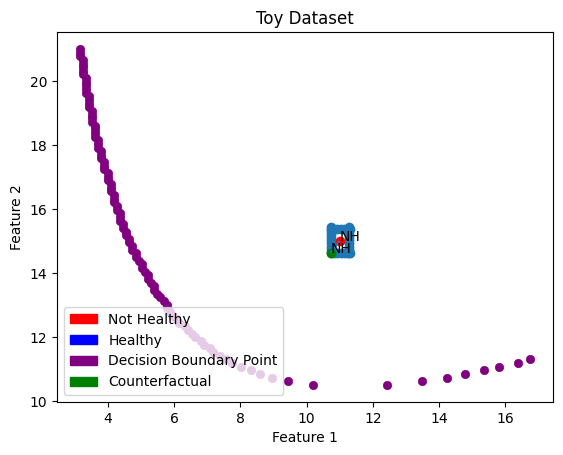

[np.float64(10.723996350364963), np.float64(14.62399732620321)]

In [13]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, original_class=1, resolution=150, chosen_row=4, point_epsilon=0.1, epsilon=0.07, constraints=[], deltas=[5] * 2, plot=True)
optimal_projection

# Setting Constraints on Each Dimension 

Below, we define the dataset using an SVM classifier, where we specify constraints on each dimension. This means that for the given undesired (unhealthy point) coordinates $(11,15)$, we can define constraints on $x$ and $y$. This means that both $x$ and $y$ are defined within the two bounds $(x - \frac{0.15*x}{2}, x + \frac{0.15*x}{2})$ and $(y - \frac{0.15*y}{2}, y + \frac{0.15*y}{2})$. Below, we set $x = 11$ and $y = 15$, generating the box we see below. 

Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...


/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
[[1.00121359 1.00088968]]
[[-0.825 -1.125]]


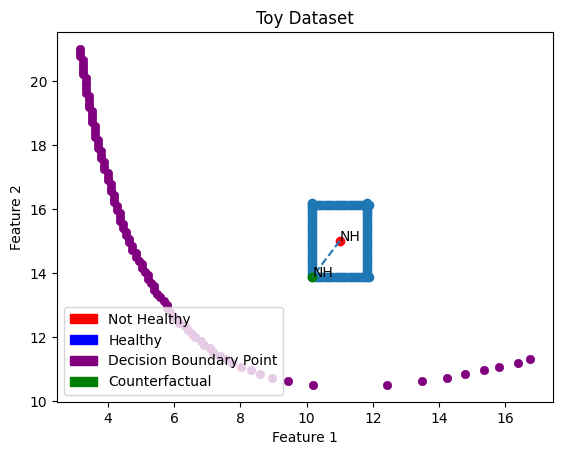

[np.float64(10.173998786407768), np.float64(13.873999110320284)]

In [14]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, original_class=1, resolution=150, chosen_row=4, point_epsilon=0.1, epsilon=0.07, constraints=[], deltas=[15] * 2, plot=True)
optimal_projection

# Defining in $N$ or fewer dimensions 

Below, we define constraints for a single dimension while letting the other constraint run free. In this case, we define a $15$% constraint around the undesired coordinate y-value while leaving the $x$ coordinate fixed. This means that the y bounds highlighted in blue below are between $(y - \frac{0.15*y}{2}, y + \frac{0.15*y}{2})$. 

Similarly, we can do the same thing while constraining only $x$ and letting $y$ run freely.

Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...


/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
[[1.00123292 1.00022244]]
[[-0.81208054 -4.4966443 ]]


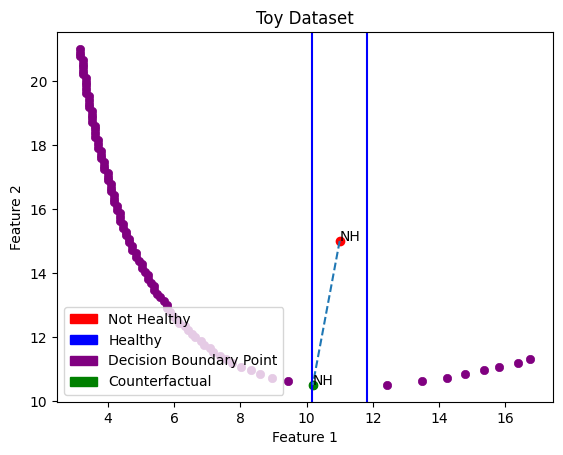

[np.float64(10.186918230164062), np.float64(10.50235548226046)]

In [15]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, original_class=1, resolution=150, chosen_row=4, point_epsilon=0.1, epsilon=0.07, constraints=[], deltas=[15,None], plot=True)
optimal_projection

# Binary Search Approach (Euclidean Space)

Consider an N-dimensional Euclidean space where a given point x is represented as ($x_1$, $x_2$, ..., $x_n$) in the space. 

If we consider two such points, $x_1$ and $x_2$, which are members of different classes, we can find a decision boundary point by performing a binary search. 

Take the midpoint of the two endpoints and evaluate which class the midpoint lies. From that midpoint, it will match one of two endpoints and not the other. Take the midpoint and the non-matching point. Iterate until it is smaller than some epsilon value. 

# Loading in cuML acceleration library (RAPIDS GPU library)

In [ ]:
def multi_alpha_binary_search(model, points, opp_points, point_target, epsilon=1e-3, max_iter=100):
    zeros_df, ones_df = np.zeros((points.shape[0], 1)), np.ones((points.shape[0], 1))
    alpha_df = pd.DataFrame(data=np.hstack((zeros_df, ones_df)), columns=['begin', 'end'])

    for _ in range(max_iter):
        # Look for midpoints
        mids = (alpha_df['begin'] + alpha_df['end']) / 2
        mids = np.reshape(mids, (-1, 1))
        mid_points = (1 - mids) * points + mids * opp_points
        # Make predictions for the model from mid points
        preds = model.predict(mid_points)
        rows = np.where(preds == point_target)[0]
        other_rows = np.where(preds != point_target)[0]
        # Fix beginning and ending columns
        true_idx, false_idx = rows, other_rows
        alpha_df.loc[true_idx, 'begin'] = mids[true_idx,0]
        alpha_df.loc[false_idx, 'end'] = mids[false_idx,0]

        if (np.abs(alpha_df['begin'] - alpha_df['end']) < epsilon).all():
            break
        # For testing
        # assert true_idx.shape[0] + false_idx.shape[0] == alpha_df.shape[0]
    return (alpha_df['begin'] + alpha_df['end']) / 2

def multi_decision_boundary(model, X, y, epsilon=1e-3, threshold=10000, batch=1000):
    """
    Approximate the decision boundary of a binary classification model by sampling
    points along line segments between correctly classified points from opposite
    classes. Uses binary search to find transition points and collects them into
    a DataFrame. Handles categorical features by rounding them to integers.

    Parameters
    ----------
    model : object
        A trained binary classification model with a `predict` method that takes
        a list or array of input points and returns predictions as an array.
        Example: sklearn.svm.SVC instance.

    X : pandas.DataFrame
        The feature dataset, where rows are samples and columns are features.
        Supports mixed types, including integer categoricals.

    y : pandas.Series or numpy.ndarray
        The target labels corresponding to X. Must contain exactly two unique
        binary labels (e.g., 0 and 1).

    epsilon : float, optional
        The precision for the binary search in `alpha_binary_search`. Smaller
        values increase accuracy but computation time. Default is 1e-3.

    threshold : int, optional
        The maximum number of boundary points to generate. Stops early if reached
        to prevent excessive computation on large datasets. Default is 10000.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the approximated boundary points, with the same
        columns as X. Categorical columns (detected as int types) are converted
        to integers.

    Raises
    ------
    ValueError
        If y does not contain exactly two unique labels (non-binary classification).

    Notes
    -----
    - This function clusters points by true labels (y), then filters pairs where
      the model correctly predicts them (to ensure opposite sides of the boundary).
    - It may miss boundaries if the model has high error rates (few correct pairs).
    - Computational complexity is O(n*m) where n and m are cluster sizes, capped
      by threshold. For large datasets, reduce threshold or sample clusters.
    - A `bool_vec` is created but unused; it may be a remnant for future masking
      (e.g., to ignore categoricals in interpolation).
    - Categorical features are auto-detected as int columns and rounded to int
      in the output for interpretability.
    - Usage: Call after training a model to visualize or analyze its boundary,
      e.g., plot the points in 2D or use for explanations.

    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> from sklearn.svm import SVC
    >>> X = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0]})
    >>> y = np.array([0, 1, 0])
    >>> model = SVC(kernel='linear').fit(X, y)
    >>> boundary = find_decision_boundary(model, X, y, epsilon=0.001, threshold=5)
    >>> print(boundary.shape)  # e.g., (number_of_points, 2)
    (2, 2)
    """
    # Detect categorical features (assumed as int columns)
    categorical_features = X.select_dtypes(include='int32').columns.tolist()

    X_np = X.to_numpy()  # Convert features to NumPy for efficient ops
    y_np = y.to_numpy() if not isinstance(y, np.ndarray) else y  # Ensure y is NumPy
    boundary_points = []  # List to collect boundary point arrays
    unique_labels = np.unique(y_np)  # Get unique class labels

    if len(unique_labels) != 2:
        raise ValueError("Only supports binary classification.")

    label_a, label_b = unique_labels[0], unique_labels[1]  # Assign labels

    # Cluster points by true labels
    cluster_a = X_np[y_np == label_a]
    cluster_b = X_np[y_np == label_b]

    # After creating cluster_a and cluster_b
    preds_a = model.predict(cluster_a)
    preds_b = model.predict(cluster_b)

    if isinstance(preds_a, np.ndarray) and len(preds_a.shape) > 1:
        preds_a = np.argmax(preds_a, axis=1)
        preds_b = np.argmax(preds_b, axis=1)

    # Separating the clusters where they have both
    # correctly predicted and labeled
    correct_a = cluster_a[preds_a == label_a]
    correct_b = cluster_b[preds_b == label_b]

    # A covariate matrix for the dataset
    cov_matrix = np.cov(X, rowvar=False)

    # Appending to the possible set of points using
    # Gaussian sampling centered around data point
    for sample, label in chain(zip(correct_a, label_a), zip(correct_b, label_b)):
        gaussian_samples = gaussian_sample_generator(classifier=model, sample=sample,
                                  cov_matrix=cov_matrix, columns=X.columns, label=label,
                                  size=1000)
        if label == label_a:
            correct_a = np.concat((correct_a, gaussian_samples))
        else:
            correct_b = np.concat((correct_b, gaussian_samples))

    # Taking the minimum of the threshold
    #  number of allowed decision boundary points with the number of
    # possible points from each class
    num_pairs = min(threshold, correct_a.shape[0] * correct_b.shape[0])  # Avoid overflow
    a_indices = np.random.choice(correct_a.shape[0], num_pairs, replace=True)
    b_indices = np.random.choice(correct_b.shape[0], num_pairs, replace=True)

    # Initialize empty set of boundary points
    boundary_points = []

    for idx in range(0, num_pairs, batch):
        points = correct_a[a_indices[idx:idx+batch]]
        opp_points = correct_b[b_indices[idx:idx+batch]]
        # Generating alphas (batch, usually grouped in a 1000 or 10,000)
        # used for locating decision boundary points
        # Then appending decision boundary points to the
        # set of boundary points
        alphas = multi_alpha_binary_search(model, points, opp_points, label_a, epsilon=epsilon)
        alphas = np.reshape(alphas, (-1, 1))
        boundary_pts = (1 - alphas) * points + alphas * opp_points
        # Append decision boundary points
        boundary_points.append(boundary_pts)

    # Convert list to DataFrame with original columns
    boundary_pts = np.concat(boundary_points,axis=0)
    boundary_pts = pd.DataFrame(data=boundary_pts, columns=X.columns)

    return boundary_pts

# Revised Optimal Point using Binary Search Approach 

Instead of using the ```optimal_point()``` function with the grid-based approach, we can use the above function to retrieve decision boundary points using the binary search approach. 

We generally choose a small epsilon to find points that best matches those of decision boundary points. 

We changed the parameter ```resolution``` with ```threshold```. ```resolution``` refers to the size of one of the dimensions of a high-dimensional cube whereas ```threshold``` refers to the number of decision boundary points that we want to find using the binary search approach. 

In [ ]:
def optimal_point(dataset, model, desired_class, original_class, chosen_row=-1, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[], plot=False):
    """
    Finds the closest point to the decision boundary from an undesired point,
    optionally constrained by real-world conditions.
    This essentially finds the counterfactual explanation for a given point by minimizing the distance to the given boundary.
    This method is important because it addresses a key problem with the original optimal_point() function where we generated an R^n dimensional grid that we would then have to iterate over.
    The problem with iterating over such a grid is eventually that we will hit a memory error for high-dimensional features such as 20, 30 or 40 features. This will cause the function to crash.
    Additionally, due to the exponential increase of the number of features to search, the grid will become infeasible to search (curse of dimensionality).

    Parameters
    ----------
    dataset : pd.DataFrame
        Full dataset containing features and a final column with class labels.

    model : sklearn-like classifier
        A binary classification model with a `.fit()` and `.predict()` method.

    desired_class : int or label
        The target class we want the corrected point to belong to.

    original_class : int or label
        The actual class label of the undesired point.

    chosen_row :  int
        The selected row of the dataset to find the counterfactual explanation for

    threshold : int, optional
        Max number of decision boundary points to generate. Default is 10000.

    point_epsilon : float, optional
        Precision used to estimate decision boundary points. Default is 0.1.

    epsilon : float, optional
        Step size used when displacing a point toward the decision boundary. Default is 0.01.

    constraints : list, optional
        A list of real-world constraints on the features (e.g., ranges, logic constraints). Default is [].

    deltas : list, optional
        Tolerances or maximum displacements for each continuous feature. Only works for continuous features. Default is [].

    plot : boolean
        Used as a parameter to determine whether to plot the results or not

    Returns
    -------
    np.ndarray
        A corrected point that satisfies the class change and real-world constraints.

    Raises
    ------
    Exception
        If the number of constraints exceeds the number of features.

    Notes
    -----
    - This function trains the model on the provided dataset, generates boundary points using
      `find_decision_boundary`, applies constraints, and finds the closest optimal point.
    - Assumes binary classification and relies on external functions like `real_world_constraints`,
      `closest_point`, `move_from_A_to_B_with_x1_displacement`, etc., which must be defined elsewhere.
    - Includes plotting for visualization (e.g., boundary contours, points), which requires matplotlib.
    - The function blends boundary approximation with counterfactual generation, useful for explainable AI.
    - Print statements are for progress tracking; plotting is partially commented out but can be enabled.
    - Usage: Call with a dataset and model to generate counterfactuals, e.g., for model interpretation or optimization.

    Examples
    --------
    >>> import pandas as pd
    >>> from sklearn.linear_model import LogisticRegression
    >>> dataset = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0], 'label': [0, 1, 0]})
    >>> model = LogisticRegression()
    >>> undesired_coords = [2, 0]  # Example point from class 0
    >>> optimal = optimal_point(dataset, model, desired_class=1, original_class=0, undesired_coords=undesired_coords)
    >>> print(optimal)  # e.g., array([[1.5, 0.5]])
    """

    # Convert categorical columns if needed (before balancing)
    inv_col_map = convert_columns(dataset)

    # Extract features and labels before balancing
    X_orig = dataset.iloc[:, :-1]

    # Save the original row's feature values
    undesired_coords = X_orig.iloc[chosen_row, :].copy()

    # Balance the dataset
    dataset = balance_dataset(df=dataset, target=dataset.columns[-1])

    if not check_class_balance(dataset, target=dataset.columns[-1]):
        raise RuntimeError("Failed to balance classes for binary classification")

    sampled_dataset = dataset.sample(n=min(dataset.shape[0], 20000))

    # Extract new training features/labels after balancing
    X_train = sampled_dataset.iloc[:, :-1]
    y_train = sampled_dataset.iloc[:, -1]
    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    # -------------------------------
    # STEP 2: Find decision boundary
    # -------------------------------
    print("boundary points started generation...")

    # This step uses binary interpolation to get points close to the decision boundary
    boundary_points = multi_decision_boundary(model, X_train, y_train,
                                             threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)

    # -------------------------------
    # STEP 3: Apply real-world constraints (optional)
    # -------------------------------
    # Reduce boundary points based on external rules (e.g., cost limits, physics constraints)
    contours_pd = real_world_constraints(points=boundary_points, undesired_coords=undesired_coords, constraints=constraints)

    # contours = boundary_points  # (Commented: Alternative to use raw boundary)
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))  # Reshape undesired point to 2D array

    # -------------------------------
    # STEP 4: Find closest point on constrained boundary
     # -------------------------------
    if contours_pd is not None and desired_class != original_class:
        contours = contours_pd.to_numpy()
        print("Finding the closest point from the contour line to the point...")
        contours_pd.reset_index(drop=True, inplace=True)
        optimal_datapt = closest_point(undesired_datapt, contour=contours)
        print("Found the closest point from the contour line to the point.")  # Note: Duplicate print, possibly a typo
        D = optimal_datapt - undesired_datapt  # Compute direction vector
        deltas = D * (1+epsilon)  # Scale by (1 + epsilon) to overshoot
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    elif desired_class == original_class or contours_pd is None:
        # If we want to *stay within* the same class (more constrained)
        all_constrained_feats = [var for (var,_) in constraints]
        closest_boundedpt = None
        vars = set(X_train.columns) - set(all_constrained_feats)
        cont_mutable_vars = [X_train.columns.get_loc(col) for col in vars]
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], vars=cont_mutable_vars, deltas=deltas)  # Determine constraints

        if len_constr > X_train.shape[1]:
            raise Exception("There cannot be more constraints than features")
        else:
            # All n dimensions are constrained, so generate an exact grid of boundary candidates
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0],
                                                              extents=deltas,
                                                              step=0.1)
            np_bounded_contour = np.array(bounded_contour_pts)  # Convert to NumPy array
            if plot:
                x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
                plt.scatter(x_values, y_values, marker='o')  # Plot bounded points

            closest_boundedpt = closest_border_point(np_bounded_contour, contour=boundary_points)  # Find closest on border
            print(closest_boundedpt)
        D = closest_boundedpt - undesired_datapt  # Compute direction
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)  # Move point

    # Plot original and optimal points with connecting line
    if plot and contours_pd is not None:
        contours = contours_pd.to_numpy()
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)
        plt.scatter(contours[:,0], contours[:,1], lw=0.5, color='purple', label="Decision Boundary Points")  # Commented: Plot contours for visualization
        plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r', label="NH: Not Healthy")  # Plot undesired point
        plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')  # Label 'NH' (e.g., Non-Healthy)
        plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'g', label="H: Healthy")  # Plot optimal point (changed to green for distinction)
        plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
        plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')  # Dashed line between points
        red_patch = mpatches.Patch(color='red', label='Not Healthy')
        blue_patch = mpatches.Patch(color='blue', label='Healthy')
        green_patch = mpatches.Patch(color='green', label="Counterfactual")
        purple_patch = mpatches.Patch(color='purple', label='Decision Boundary Point')
        plt.legend(loc='lower left', handles=[red_patch, blue_patch, purple_patch, green_patch])
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title("Toy Dataset")
        plt.show()

    categorical_features = [col for col in inv_col_map.keys()]
    final_optimal_datapt = []

    for col in X_train.columns:
        if col in categorical_features:
            idx = int(optimal_datapt[0,X_train.columns.get_loc(col)])
            final_optimal_datapt.append(inv_col_map[col][idx])
        else:
            final_optimal_datapt.append(optimal_datapt[0,X_train.columns.get_loc(col)])

    return final_optimal_datapt

Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5, 2)
Finding the closest point from the contour line to the point...
Found the closest point from the contour line to the point.
[[1.00880053 1.01022269]]
[[ 0.84104013 -4.53641605]]


/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


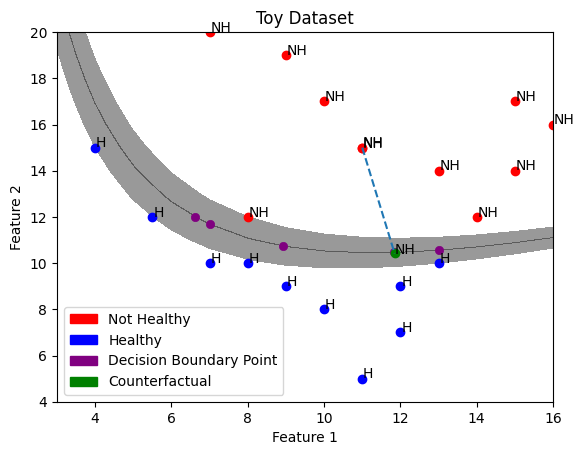

[np.float64(11.848441735241998), np.float64(10.417209562998499)]

In [19]:
visualize_dataset()
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=5, chosen_row=4, constraints=[], epsilon=0.01, point_epsilon=1e-6, plot=True)

/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Found the closest point from the contour line to the point.
[[1.01301989 1.01022311]]
[[-0.33544922 -4.52783203]]


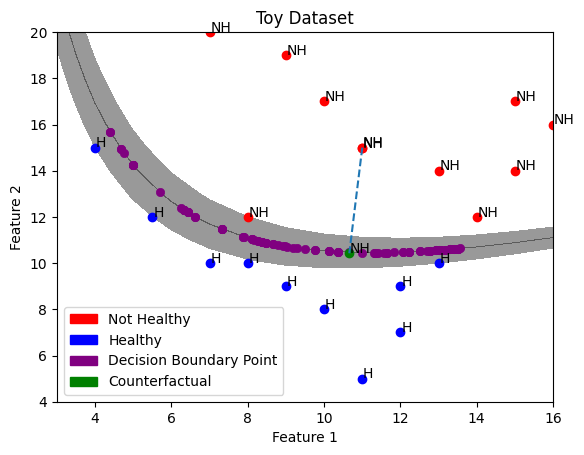

[np.float64(10.660183269172055), np.float64(10.425879425323412)]

In [20]:
visualize_dataset()
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100,  chosen_row=4, epsilon=0.01, constraints=[], plot=True, point_epsilon=1e-3)

# Setting Constraints with Binary Search Approach # 

Similar to before, we can define a set of constraints on both dimensions. This means that both $x$ and $y$ are defined within the two bounds $(x - \frac{0.15*x}{2}, y + \frac{0.15*y}{2})$. Here, we define a $15%$ interval around the point $(x,y)$ using the respective $x$ and $y$ to define the deltas in both directions.

Below, we set $x = 11$ and $y = 15$, generating the box we see below. 

Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
[[1.00121359 1.00088968]]
[[-0.825 -1.125]]


/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


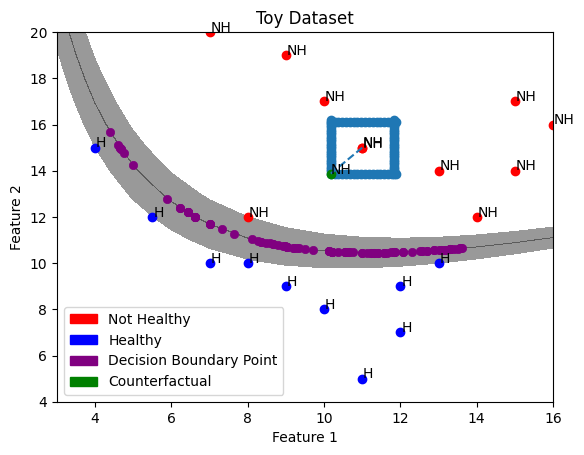

[np.float64(10.173998786407768), np.float64(13.873999110320284)]

In [21]:
visualize_dataset()
optimal_projection = optimal_point(df, svm_classifier, threshold=100, chosen_row=4, desired_class=-1, original_class=-1, point_epsilon=1e-3, epsilon=0.01, deltas=[15]*2, plot=True)
optimal_projection

Similarly, we do the same thing with a larger box around the point $(x,y)$, but in this case, we define a $25%$ interval around the point $(x,y)$ in which we define a bound around (x,y) as $(x - \frac{x - 0.25*x}{2}, y + \frac{y + 0.25*y}{2})$. Here, we define a $25%$ interval around the point $(x,y)$ using the respective $x$ and $y$ to define the deltas in both directions.

/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
[[1.0007278  1.00053362]]
[[-1.375 -1.875]]


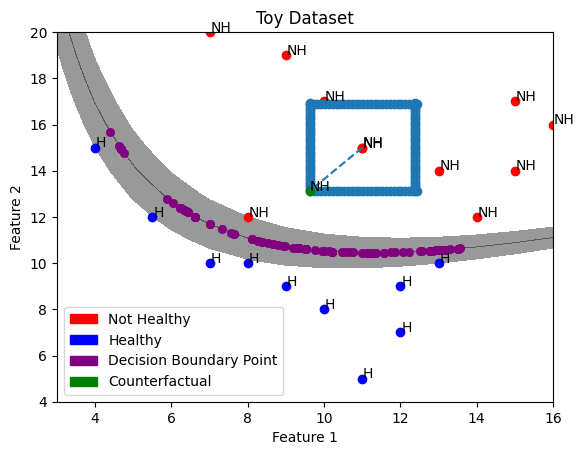

[np.float64(9.623999272197963), np.float64(13.12399946638207)]

In [22]:
visualize_dataset()
optimal_projection = optimal_point(df, svm_classifier, threshold=100, chosen_row=4, desired_class=-1, original_class=-1, point_epsilon=1e-3, epsilon=0.01, deltas=[25]*2, plot=True)
optimal_projection

/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
[[1.00015831 1.01639029]]
[[-6.31787109 -0.06201172]]


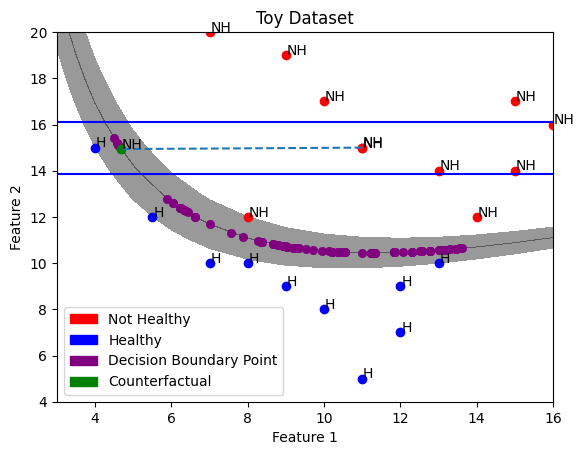

[np.float64(4.681128747943776), np.float64(14.936971890956126)]

In [23]:
visualize_dataset()
optimal_projection = optimal_point(df, svm_classifier, threshold=100, chosen_row=4, desired_class=-1, original_class=-1, point_epsilon=1e-3, epsilon=0.01, deltas=[None,15], plot=True)
optimal_projection

# Obesity Counterfactual Explanations 

The issue of counterfactual explanations is that they require multiple questions to be answered to be feasible & actionable counterfactual explanations. 

1. How do we minimize the change in the feature values and make the observed instance as similar to the original instance (Wachter 2018)? 
2. How do we identify features that change the desired outcome y'? (Pearl ...) We do not want to change features that cannot be "changed" or would be unethical to ask for such a change. Asking for the person to change gender would be unethical. Similarly asking for a person to change their height especially if they are older than 18 would be infeasible. We would want to condition on those variables which affect the value of the outcome Y which we cannot change. 
3. Feasible Constraints (Mahajan 2019; Poyiadzi 2019) -- How do we ensure that the change is "actionable"? Let's say that the person is under the age of 18 and still growing. Does it make sense to change the person's height by a foot for a counterfactual explanation? Can we say that a person should take 50 doses of a given drug every day? We should make changes or treatments reasonable and ethical. 

For this problem, we only address $1$ and $3$. For addressing $2$ in this setting, we use domain knowledge to find features that would make sense to change. For settings that do not have access to domain knowledge, methods such as causal discovery would be able to construct structural causal models necessary to identify such features. 

For this setting, we use a observational dataset of 2000 samples from an obesity dataset. Domain knowledge in this setting is not difficult to obtain. There are four levels of obesity, but in this case, we change the labeling so that obesity levels equate to being obese. In this setting, we deal with a binary classification problem where there are two classes, "normal" or "obese." 

In weight analysis, we can use domain knowledge to our deconstruction of the problem. 

Let's identify the variables which are changeable (actionable) and identify features that change the outcome?


1. Identify features that are actionable (treatment) 

- Gender --> Cannot change (Not able to influence)
- Age --> Can change (cannot decrease age) 
- height --> Cannot change (Not able to influence)
- Weight --> Can change (Able to influence)
- family_history_with_overweight --> not changeable 
- FAVC --> Changeable (Able to influence)
- FCVC --> Changeable (Able to influence)
- CAEC --> Changeable (Able to influence)
- NCP ---> Changeable (Able to influence) 
- SMOKE --> Changeable (Able to influence) 
- CH2O --> Changeable (Able to influence) 
- SCC --> Changeable (Able to influence) 
- FAF --> Changeable (Able to influence) 
- TUE --> Changeable (Able to influence) 
- CALC --> Changeable (Able to influence) 
- MTRANS --> Changeable (Able to influence) 
- Obesity -- Target (Not able to influence; dependent variable)


2. Identify features that affect the outcome 

We use the five most important features selected by the paper (Yagin et. al. 2023). They apply a neural network optimized using Bayesian optimization techniques. 

By mutual information classify, these variables are FAVC, SMOKE, FAF, CALC, FCVC (Yagin et. al. pg 8)

In [92]:
obesity_df = pd.read_csv(
'ObesityDataSet_raw_and_data_sinthetic.csv'
)
obesity_df['NObeyesdad'] = (obesity_df['NObeyesdad'] != "Normal_Weight").astype(int)

# Define Real World Constraints for the Given Obesity Problem 

We can define constraints so that the given counterfactual explanation aligns with the given observation. For the given observation who is a 27 year old male with a height of 1.8 meters, we expect the counterfactual to fit the constraints of having the same gender and having similar age and height. 

Our dataset has $16$ features and a single target variable which is whether the person has obesity or not. 

We define $15\%$ constraints around non-categorical features and leave categorical features unchanged.

In [93]:
categorical_cols = obesity_df.select_dtypes(include=["object"]).columns.tolist()
print(categorical_cols)

['Gender', 'CALC', 'FAVC', 'SCC', 'SMOKE', 'family_history_with_overweight', 'CAEC', 'MTRANS']


In [94]:
obesity_df.columns = [col.lower() for col in obesity_df.columns]
categorical_cols = obesity_df.select_dtypes(include=["object"]).columns.tolist()
immutable_features = ['age', 'height']
immutable_features.extend(categorical_cols)
print(immutable_features)

['age', 'height', 'gender', 'calc', 'favc', 'scc', 'smoke', 'family_history_with_overweight', 'caec', 'mtrans']


# Defining Delta Constraints

For mutable, numerical features, we set a $15\%$ in terms of what the feature is allowed to changem, but for categorical and immutable features, we set this to be $0$.

In [ ]:
delta_constraints = []
for col in obesity_df.columns:
    if col not in immutable_features:
        delta_constraints.append(15)
    else:
        delta_constraints.append(0)

Below is what our features of our dataset looks like.

In [96]:
obesity_df.head(n=20)

,age,gender,height,weight,calc,favc,fcvc,ncp,scc,smoke,ch2o,family_history_with_overweight,faf,tue,caec,mtrans,nobeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,0
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,0
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,0
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,1
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,1
5,29.0,Male,1.62,53.0,Sometimes,yes,2.0,3.0,no,no,2.0,no,0.0,0.0,Sometimes,Automobile,0
6,23.0,Female,1.50,55.0,Sometimes,yes,3.0,3.0,no,no,2.0,yes,1.0,0.0,Sometimes,Motorbike,0
7,22.0,Male,1.64,53.0,Sometimes,no,2.0,3.0,no,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,0
8,24.0,Male,1.78,64.0,Frequently,yes,3.0,3.0,no,no,2.0,yes,1.0,1.0,Sometimes,Public_Transportation,0
9,22.0,Male,1.72,68.0,no,yes,2.0,3.0,no,no,2.0,yes,1.0,1.0,Sometimes,Public_Transportation,0


In [ ]:
for col in obesity_df.columns:
    print(col, obesity_df[col].dtype)

age float64
gender object
height float64
weight float64
calc object
favc object
fcvc float64
ncp float64
scc object
smoke object
ch2o float64
family_history_with_overweight object
faf float64
tue float64
caec object
mtrans object
nobeyesdad int64


This is the observation that we are trying to find the counterfactual explanation for. 

In [89]:
obesity_df.iloc[3,:obesity_df.shape[1]-1]

age                                     27.0
gender                                  Male
height                                   1.8
weight                                  87.0
calc                              Frequently
favc                                      no
fcvc                                     3.0
ncp                                      3.0
scc                                       no
smoke                                     no
ch2o                                     2.0
family_history_with_overweight            no
faf                                      2.0
tue                                      0.0
caec                               Sometimes
mtrans                               Walking
Name: 3, dtype: object

# Generated counterfactual 

From the given male user above with a height of $1.8$ meters and of age 27, we find that the generated counterfactual is the array below. Given that we sample a small grid around the original point, there is a point of spacing that makes the age and height slightly inaccurate, but the other values are allowed to be changed up to $15\%$.

In [97]:
optimal_projection = optimal_point(obesity_df, svm_classifier, desired_class=0, original_class=1, threshold=10000, chosen_row=3, epsilon=1e-3, deltas=delta_constraints)
optimal_projection

/tmp/ipykernel_934/3739720189.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 nobeyesdad
0    1824
1    1824
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(10000, 16)
Finding the closest point from the contour line to the point...
Found the closest point from the contour line to the point.
[[1.0131371905692756 0.0 0.9830240760205595 1.0023637938947743
  0.9980964467005076 1.0 1.0039710013866279 0.0 0.0 0.0 1.018868219648794
  0.9980964467005076 1.0034269054962301 0.9855441881718068
  1.0017632481890963 1.002002002002002]]
[[-0.08347378124999949 0.0 0.05468559375000015 -0.7349818749999883
  0.34375 1.0 -0.33792343749999976 0.0 0.0 0.0 -0.05702125000000002
  0.34375 -0.4134594062499999 0.06376528125 -1.3125 -1.0]]


[26.915429607778183,
 'Male',
 1.8537572552677297,
 86.26328077933111,
 'Frequently',
 'yes',
 2.6607346680611137,
 3.0,
 'no',
 'no',
 1.9419028605303512,
 'no',
 1.585123707438254,
 0.06284350234307819,
 'Always',
 'Motorbike']